-----
# 1. 필요 라이브러리 호출

-----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd 
import konlpy
# import gensim
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras.utils import plot_model
from konlpy.tag import Okt
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization

tf.__version__

'2.8.2'

-------
# 2. 데이터 준비와 확인

--------

In [4]:
# 데이터 불러오기 
train = pd.read_table('/content/drive/MyDrive/aiffel/Exp9/ratings_train.txt')
test = pd.read_table('/content/drive/MyDrive/aiffel/Exp9/ratings_test.txt')

train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


-------
# 3. 데이터 전처리

------


- train은 총 15만개의 데이터, test는 5만 개의 데이터와 id / document / label 로 이루어진 데이터셋이다.

In [5]:
train['document'][2] = train['document'][2].replace('너무재밓었다그래서보는것을추천한다','너무재밌었다그래서보는것을추천한다')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
test.shape

(50000, 3)

In [7]:
train.shape

(150000, 3)

- 결측치 확인

In [8]:
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

- 결측값이 있는 행 확인

In [9]:
train_null = train[train['document'].isnull()].index
train_null

Int64Index([25857, 55737, 110014, 126782, 140721], dtype='int64')

- 결측값 제거

In [10]:
train.drop(train_null,axis=0,inplace=True)

- 결측값 제거 확인

In [11]:
train = train.reset_index(drop=True)

In [12]:
train.shape

(149995, 3)

- 중복값 확인

In [13]:
train.duplicated(subset='document').sum()

3813

- 3813개의 중복된 행을 보니 [재밌다,최고,짱 등] 간단한 리뷰를 남겨서 중복값으로 표현이됨  
다만, 자세히 들여다 본 결과 ㅋ과 같은 경우 한 컬럼의 label은 1로 되어있고 다른 컬럼의 label은 0으로 되어 있어 혼란을 줄 여지가 있어 보인다.

In [14]:
train[train.duplicated(subset='document')]

,id,document,label
1058,5890638,4,0
1097,2062443,쵝오,1
1248,3502685,최고,1
1483,775332,최고,1
1707,8009134,재밌다,1
...,...,...,...
149914,6502490,짱,1
149944,3924716,OO 영화,0
149955,6368431,지루하다,0
149961,6735753,1,0


- 한글,영어 표현만 남기기

참고 블로그<https://haystar.tistory.com/11>

In [15]:
def extract_word(text):
  hangul = re.compile('^\d*\d$|[^가-힣a-zA-Z0-9]')
  result = hangul.sub(' ',text)
  return result

In [16]:
print("Before Extraction : ",train['document'][9745])
print("After Extraction : ", extract_word(train['document'][9745]))
print('='*50)
print("Before Extraction : ",train['document'][8045])
print("After Extraction : ", extract_word(train['document'][8045]))
print('='*50)
print("Before Extraction : ",train['document'][3])
print("After Extraction : ", extract_word(train['document'][3]))
print('='*50)
print("Before Extraction : ",train['document'][19407])
print("After Extraction : ", extract_word(train['document'][19407]))
print('='*50)
print("Before Extraction : ",train['document'][26259])
print("After Extraction : ", extract_word(train['document'][26259]))
print('='*50)
print("Before Extraction : ",train['document'][115278])
print("After Extraction : ", extract_word(train['document'][115278]))

Before Extraction :  전기세가 아깝다!!!
After Extraction :  전기세가 아깝다   
Before Extraction :  1
After Extraction :   
Before Extraction :  교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
After Extraction :  교도소 이야기구먼   솔직히 재미는 없다  평점 조정
Before Extraction :  ㅋㅋㅋ
After Extraction :     
Before Extraction :  Two thumbs up!!
After Extraction :  Two thumbs up  
Before Extraction :  1점
After Extraction :  1점


In [17]:
train['document'] = train['document'].apply(lambda x:extract_word(x))

In [18]:
for i in range(len(train)):
  train['document'][i] = re.sub(r'[" "]+', " ", train['document'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
null = train[train['document'] == ' '].index
null

Int64Index([   584,    593,    972,   1058,   1840,   2159,   2327,   2504,
              2648,   2840,
            ...
            148553, 148555, 148935, 149151, 149359, 149393, 149440, 149713,
            149857, 149961],
           dtype='int64', length=675)

In [20]:
len(train)

149995

In [21]:
train.drop(null,axis=0,inplace=True)
train = train.reset_index(drop=True)

In [22]:
len(train)

149320

- 긍정리뷰와 부정리뷰의 비율 확인

확인결과 대충 봐도 반반 정도가 되는 것을 알 수 있다.

In [23]:
train['label'].value_counts()

0    74780
1    74540
Name: label, dtype: int64

- 리뷰 데이터 중 재미있다고 표현했지만 label이 0으로 표현(반대의 경우도 존재)되어 있는 케이스가 종종 있어서 해당 값을들 맞게 끔 변환시켜 주려한다.

In [24]:
# 0에서 1로 / 1에서 0으로 바꿔주는 함수 생성
def replace0to1(x):
  train['label'].loc[x] = 1


def replace1to0(x):
  train['label'].loc[x] = 0


- 재미있다고 표현한 데이터 중 label이 오표기 된 데이터가 별로 안되니 직접 눈으로 보고 수정하겠다.


In [25]:
data = train.loc[train['document'].str.contains(r'재미있다[^가-힣]')]
data = data[data['label'] == 0]
data

,id,document,label
3116,3645587,아 정말 재미있다 이걸 보는 사람에게 강추한다 꼭 보십시오,0
6296,6984740,성냥팔이 소녀의 재림도 이 영화보다는 백번 재미있다,0
11697,10213278,생각보다 재미없고 러닝 타임이 너무길다 안젤리나 졸리는 여전사 영화 원티드 솔트 툼...,0
26276,7440673,와 재미있다,0
28993,9939577,사랑과 전쟁이 훨씬 재미있다,0
30524,3457518,재미없다 한국영화가 더 재미있다 평점이 2 95,0
37820,8606949,디워 보다는 재미있다,0
41332,1675603,전원일기가 월 감동적이고 재미있다,0
46271,3385718,오 재미있다,0
54010,9938346,이건 똥쓰레기 영화는 드래곤볼 영화도 아니다 드래곤볼 gt도 이것보단 9999억배 ...,0


한국어는 어렵다... 글은 재밌다고 하지만 읽어보면 정반대의 뉘앙스를 풍기는 것들이 많다...  
특히 영화계에서 클레멘타인 만큼 재밌다는 것은 악평 중 악평이다....  
읽어보고 내 맘대로 수정하겠다.

In [26]:
ota = ['3116','26276','46271','55313','67394','80089']

for i in ota:
  replace0to1(i)

In [27]:
data = train.loc[train['document'].str.contains(r'재미[^가-힣]')]
data

,id,document,label
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
221,9324383,진심 재미 없는데 너무 평점 높아서 화남,0
263,6931068,필름값이 아깝다 재미 더럽게없다 2점부터 점수준것들 매미 OO,0
370,8652917,초딩 때 친척형이 비디오로 빌려와서 봤던 기억이 난다 너무 재미 없었다 근데 나중에...,1
462,6150881,진짜 재미 없는 영화 공통점 스포츠영화 군대영화 자막 나오는 영화,0
...,...,...,...
148660,7140145,13 14회 생각보다 재미 없네요 엄청 기대했는데 역시 청앨은 밝은 스토리 전개가 ...,0
148693,9979801,그냥 영화 자체가 너무 재미 없다 80 90 년대 모세 영화 애니와 비교하면 쓰레기...,0
149055,9405899,신선한 소재로 너무 재미 있어요 일찍자는편인데 수요일은 본방사수 그담날은 아기랑 같...,1
149094,7397453,재미 드럽게 없다 내용이 음슴,0


리뷰의 길이가 더 긴 값을 하면 라벨링이 잘못된 데이터를 찾을 수 있겠지만 그러면 눈이 너무 피로할테니 10으로만 하겠다.

In [28]:
# 리뷰의 길이가 10 이하인 리뷰 중 label이 0인 값
revise = []
for i in range(len(data)):
  revise.append((len(data['document'][data.index[i]]) <= 10) & (data['label'][data.index[i]] == 0))
data[revise]

,id,document,label
951,8051141,재미 드럽게 없다,0
2293,2098505,대략 재미 없음,0
5964,792756,재미 없다,0
7663,1519544,솔직히 재미 없다,0
10763,3490967,재미 x,0
...,...,...,...
133814,6632641,재미 더럽게없네,0
135542,7427273,재미 더럽게없다,0
136476,7651922,재미 없다,0
143582,7517697,진짜 재미 없음,0


In [29]:
ota = ['21760']

for i in ota:
  replace0to1(i)

In [30]:
# 리뷰의 길이가 10 이하인 리뷰 중 label이 0인 값
revise = []
for i in range(len(data)):
  revise.append((len(data['document'][data.index[i]]) <= 10) & (data['label'][data.index[i]] == 1))
data[revise]

,id,document,label
14103,7989370,고전 영화의 재미,1
17967,6215574,완전 재미 있어요,1
19701,4758621,재미 있어요,1
21040,6768185,재미 있어요,1
21069,5675366,예고부터 재미 어요,1
24413,1412766,정말 재미 있음,1
24477,6114418,재미 있습니다,1
26544,2153745,빅재미 터진다,1
29219,5156544,재미 있습니다,1
39990,4162549,재미 짱,1


In [31]:
ota = ['62306','131063']

for i in ota:
  replace1to0(i)

In [32]:
train = train.reset_index(drop=True)

형태소 분석

Hannanum(한나눔) - KAIST 말뭉치를 이용해 생성된 사전   
Kkma(꼬꼬마) - 세종 말뭉치를 이용해 생성된 사전 -> 정확한 품사 분류   
Mecab(메캅) - 세종 말뭉치로 만들어진 CSV형태의 사전  
Komoran(코모란) - Java로 쓰여진 오픈소스 한글 형태소 분석기 -> 정확성과 속도  
Twitter(Okt) - 오픈소스 한글 형태소 분석기 -> 빠른 분석  



In [40]:
from konlpy.tag import Komoran
komoran=Komoran()

In [41]:
#형태소 추출

a = []
for i in range(len(train)):
  a.append(komoran.morphs(train['document'][i]))

In [42]:
len(a)

149320

In [43]:
corpus = []
for i in range(len(a)):
  for j in range(len(a[i])):
    corpus.append(a[i][j])


In [44]:
len(corpus)

2644639

불용어 제거

In [45]:
with open('/content/drive/MyDrive/aiffel/Exp9/stopword.txt', 'r',encoding='utf-8') as f:
    list_file = f.readlines()
stopword = []
for i in range(len(list_file)):
  stopword.append(list_file[i].split())
print(stopword)

[['아'], ['휴'], ['아이구'], ['아이쿠'], ['아이고'], ['어'], ['나'], ['우리'], ['저희'], ['따라'], ['의해'], ['을'], ['를'], ['에'], ['의'], ['가'], ['으로'], ['로'], ['에게'], ['뿐이다'], ['의거하여'], ['근거하여'], ['입각하여'], ['기준으로'], ['예하면'], ['예를', '들면'], ['예를', '들자면'], ['저'], ['소인'], ['소생'], ['저희'], ['지말고'], ['하지마'], ['하지마라'], ['다른'], ['물론'], ['또한'], ['그리고'], ['비길수', '없다'], ['해서는', '안된다'], ['뿐만', '아니라'], ['만이', '아니다'], ['만은', '아니다'], ['막론하고'], ['관계없이'], ['그치지', '않다'], ['그러나'], ['그런데'], ['하지만'], ['든간에'], ['논하지', '않다'], ['따지지', '않다'], ['설사'], ['비록'], ['더라도'], ['아니면'], ['만', '못하다'], ['하는', '편이', '낫다'], ['불문하고'], ['향하여'], ['향해서'], ['향하다'], ['쪽으로'], ['틈타'], ['이용하여'], ['타다'], ['오르다'], ['제외하고'], ['이', '외에'], ['이', '밖에'], ['하여야'], ['비로소'], ['한다면', '몰라도'], ['외에도'], ['이곳'], ['여기'], ['부터'], ['기점으로'], ['따라서'], ['할', '생각이다'], ['하려고하다'], ['이리하여'], ['그리하여'], ['그렇게', '함으로써'], ['하지만'], ['일때'], ['할때'], ['앞에서'], ['중에서'], ['보는데서'], ['으로써'], ['로써'], ['까지'], ['해야한다'], ['일것이다'], ['반드시'], ['할줄알다'], ['할수있다'], ['할수있어'], ['임에', '틀림없다'], ['한다면'], ['

In [46]:
stopword = sum(stopword,[])

In [47]:
remove_stopwords = [x for x in corpus if x not in stopword]
len(remove_stopwords)

1847619

In [644]:
from collections import Counter
frequent = Counter(remove_stopwords).most_common()
frequent[:10]

[('ㄴ', 73126),
 ('다', 53713),
 ('영화', 53283),
 ('보', 47023),
 ('고', 45096),
 ('았', 30169),
 ('게', 28453),
 ('었', 25918),
 ('ㄹ', 25128),
 ('지', 21438)]

tokenizer

In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [50]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)       
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(remove_stopwords)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [51]:
# 단어 사전이 어떻게 구축 되어 있는지 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break
#<start>가 2번 이기 때문에 모든 행의 시작은 2였다.

1 : ㄴ
2 : 영화
3 : 다
4 : 보
5 : 고
6 : 았
7 : 게
8 : 었
9 : ㄹ
10 : 지


--------
# 4. 테스트 처리

-------

In [52]:
test.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [53]:
test_null = test[test['document'].isnull()].index
test_null

Int64Index([5746, 7899, 27097], dtype='int64')

In [54]:
test.drop(test_null,axis=0,inplace=True)

In [55]:
test = test.reset_index(drop=True)
test.shape

(49997, 3)

In [56]:
test['document'] = test['document'].apply(lambda x:extract_word(x))

In [57]:
for i in range(len(test)):
  test['document'][i] = re.sub(r'[" "]+', " ", test['document'][i])

null_test = test[test['document'] == ' '].index
null_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Int64Index([  116,   254,  1000,  1301,  1330,  1361,  1476,  1532,  1643,
             1879,
            ...
            48496, 48562, 48731, 48864, 48935, 49091, 49410, 49555, 49616,
            49927],
           dtype='int64', length=242)

In [58]:
null_test = test[test['document'] == ' '].index
null_test

len(test)

49997

In [59]:
test.drop(null_test,axis=0,inplace=True)
test = test.reset_index(drop=True)

len(test)

49755

In [60]:
#형태소 추출

b = []
for i in range(len(test)):
  b.append(komoran.morphs(test['document'][i]))

In [61]:
len(b)

49755

In [62]:
corpus_test = []
for i in range(len(b)):
  for j in range(len(b[i])):
    corpus_test.append(b[i][j])


In [63]:
len(corpus_test)

886692

In [64]:
remove_stopwords_test = [x for x in corpus_test if x not in stopword]
len(remove_stopwords_test)

618665

In [645]:
frequent_test = Counter(remove_stopwords_test).most_common()
frequent_test[:10]

[('ㄴ', 24555),
 ('영화', 18177),
 ('다', 18101),
 ('보', 15784),
 ('고', 15028),
 ('았', 10363),
 ('게', 9770),
 ('었', 8778),
 ('ㄹ', 8403),
 ('지', 7159)]

--------
# 5. word_to_index

------------

In [647]:
word_to_index = {word:index for index, word in tokenizer.index_word.items()}
word_to_index

{'ㄴ': 1,
 '영화': 2,
 '다': 3,
 '보': 4,
 '고': 5,
 '았': 6,
 '게': 7,
 '었': 8,
 'ㄹ': 9,
 '지': 10,
 'ㅁ': 11,
 '있': 12,
 '없': 13,
 '되': 14,
 '는데': 15,
 '좋': 16,
 '주': 17,
 '너무': 18,
 '기': 19,
 '적': 20,
 '정말': 21,
 '음': 22,
 '점': 23,
 '재밌': 24,
 'ㄴ다': 25,
 '내': 26,
 '어요': 27,
 '같': 28,
 '진짜': 29,
 '네요': 30,
 '않': 31,
 '만들': 32,
 '아서': 33,
 '말': 34,
 '연기': 35,
 '거': 36,
 '면': 37,
 '나오': 38,
 '최고': 39,
 'ㅂ니다': 40,
 '평점': 41,
 '뭐': 42,
 '던': 43,
 '겠': 44,
 '1': 45,
 '스토리': 46,
 '생각': 47,
 '시': 48,
 '드라마': 49,
 '사람': 50,
 '배우': 51,
 '보다': 52,
 '더': 53,
 '감동': 54,
 '싶': 55,
 '아깝': 56,
 '재': 57,
 '어서': 58,
 '내용': 59,
 '감독': 60,
 '요': 61,
 '재미있': 62,
 '그냥': 63,
 '듯': 64,
 '지루': 65,
 '중': 66,
 '재미': 67,
 '재미없': 68,
 '이렇': 69,
 '쓰레기': 70,
 '아도': 71,
 'ㄴ데': 72,
 'ㄴ가': 73,
 '냐': 74,
 '라고': 75,
 '10': 76,
 '못하': 77,
 '면서': 78,
 '모르': 79,
 '2': 80,
 '작품': 81,
 '건': 82,
 '개': 83,
 '번': 84,
 '사랑': 85,
 '보이': 86,
 '남': 87,
 '마지막': 88,
 '이건': 89,
 '액션': 90,
 '다고': 91,
 '으면': 92,
 '기대': 93,
 '완전': 94,
 '스럽': 95,

- 해당 값에 pad,bos,unk,unused 추가

In [67]:

word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력
print(index_to_word[4])     # 'ㄴ' 이 출력

<BOS>
ㄴ


In [68]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

아래는 train값을 dd라는 것으로 카피를 한 후 테스트한 결과이다.  
결과를 보면 '아 더빙 진짜 짜증나네요 목소리'라는 문장을 숫자로 토큰화 한 결과  
1[bos] 2[unk] 434[더빙] 32[진짜] 2[unk] 635[목소리] 가 나왔다.  
word_to_index를 보면 짜증이라는 단어가 있지만  
짜증 나네요라는 문장이 unk로 처리가 되어 추후 긍정,부정을 판별하는데 영향을 줄 수 있다고 판단해  
train의 리뷰도 형태소로 나누어 주겠다.


In [69]:
dd = train.copy()

In [70]:
qwe = get_encoded_sentences(dd['document'],word_to_index)

In [71]:
dd['document'][0]

'아 더빙 진짜 짜증나네요 목소리'

In [72]:
qwe[0]

[1,
 2,
 2,
 56,
 6128,
 2,
 1169,
 377,
 2,
 377,
 3141,
 7953,
 14704,
 64,
 2,
 1682,
 629,
 291]

In [73]:
index_to_word[32]

'진짜'

In [74]:
word_to_index['짜증']

174

In [75]:
#형태소 추출
for i in range(len(train)):
  train['document'][i] = komoran.morphs(train['document'][i])

# test값도 동일하게 처리 
for i in range(len(test)):
  test['document'][i] = komoran.morphs(test['document'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [76]:
# train_data = train.copy()
# for i in range(len(train)):
#   train_data['document'][i] = get_encoded_sentences(train['document'][i], word_to_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
train_data = train.copy()
train_data['document'] = get_encoded_sentences(train['document'],word_to_index)

In [78]:
test_data = test.copy()
test_data['document'] = get_encoded_sentences(test['document'],word_to_index)

- 필요 없는 id 컬럼 삭제

In [79]:
del train_data['id']
del test_data['id']

In [80]:
len(train_data)

149320

In [81]:
X_train = train_data[:int(len(train_data) * 0.8)]
X_test = train_data[int(len(train_data) * 0.8):]
print(len(X_train))
print(len(X_test))

119456
29864


In [475]:
y_train = test_data['document']
y_target = test_data['label']

In [476]:
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',maxlen=52)

- 효율적인 maxlen 값 찾기

In [86]:
total_data_text = list(X_train['document']) + list(X_test['document'])
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  18.71121751942138
문장길이 최대 :  105
문장길이 표준편차 :  15.343056363948335
pad_sequences maxlen :  49
전체 문장의 0.9353134208411465%가 maxlen 설정값 이내에 포함됩니다. 


In [477]:
X_train_np = np.array(X_train['document'])
X_test_np = np.array(X_test['document'])
X_train_target = np.array(X_train['label'])
X_test_target = np.array(X_test['label'])

In [478]:
X_train_np= tf.keras.preprocessing.sequence.pad_sequences(X_train_np,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',maxlen=52)
# --------------------------------------------------------------------------------------------------
X_test_np= tf.keras.preprocessing.sequence.pad_sequences(X_test_np,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',maxlen=52)

In [89]:
X_train_np 

array([[    0,     0,     0, ...,  7953,    33,   635],
       [    0,     0,     0, ...,    13,    34,   317],
       [    0,     0,     0, ...,   217, 30641,    28],
       ...,
       [    0,     0,     0, ...,  4540,  1215,    28],
       [    0,     0,     0, ..., 30641,    47,     8],
       [    0,     0,     0, ...,  4540,    11,     6]], dtype=int32)

In [90]:
X_test_np

array([[    0,     0,     0, ...,     2,    13,    14],
       [    0,     0,     0, ...,   118,  4540,     6],
       [    0,     0,     0, ...,  7953, 17838,  2319],
       ...,
       [    0,     0,     0, ...,     2,   970,     6],
       [    0,     0,     0, ...,     2,     2,  7398],
       [    0,     0,     0, ...,  1210,     4,     5]], dtype=int32)

--------
# 6. pykospacing
------

- 토큰을 구분하는 방법에 있어 문맥이 없이 단순 띄어쓰기로만 토큰을 구분한다면, 그 의미의 구분이 명확하지가 않다고 한다.  
- 한글에는 띄어쓰기가 중요하다. 또한 데이터 중에서 띄어쓰기가 되어 있지 않은 데이터가 있다.  
- 해당 데이터에 대한 고민을 하다가 우연히 띄어쓰기를 해주는 라이브러리를 발견하였다. 

https://ebbnflow.tistory.com/246

- 이전 전처리 단계는 형태소 분석을 통해 단어장을 만든 형태인 반면,  
  pykospacing을 사용한 전처리는 띄어쓰기 오류가 있는 문장을 띄어쓰기 한 후 공백을 기준으로 split하여 단어장을 만들 것이다.  

- 이후 형태소 기반의 단어장과 공백을 기준으로한 단어장을 두고 같은 모델에 넣어 비교를 통해  
  한국어를 사용할 때, 어떤 것을 기반으로 하는 것이 더 좋은지 비교해 보려한다.

In [ ]:
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

In [ ]:
from pykospacing import Spacing
spacing = Spacing()

해당 라이브러리를 aiffel 서버에서 돌린 후 전처리는 위와 동일하게 한 후 해당 값만 가져온 파일이다.

In [424]:
# 데이터 불러오기 
train_pykospacing = pd.read_csv('/content/drive/MyDrive/aiffel/Exp9/train_pykospacing.txt')
test_pykospacing = pd.read_csv('/content/drive/MyDrive/aiffel/Exp9/test_pykospacing.txt')

train_pykospacing.head()

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠 포스터 보고 초딩 영화 줄 오버 연기조차 가볍지 않구나,1
2,너무 재밓었다 그래서 보는 것을 추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,사이몬 페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커스...,1


In [425]:
train_pykospacing['document'][2] = train_pykospacing['document'][2].replace('재밓었다','재밌었다')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [428]:
train_pykospacing['document'][2]

'너무 재밌었다 그래서 보는 것을 추천한다'

In [429]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    
    # 불용어 제거 (Text)
    remove_stopwords = [x for x in sentence if x not in stopword]
    
    return remove_stopwords

In [431]:
aaa = train_pykospacing.copy()
for i in range(len(aaa)):
    aaa['document'][i] = aaa['document'][i].split()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [432]:
bbb = test_pykospacing.copy()
for i in range(len(bbb)):
    bbb['document'][i] = bbb['document'][i].split()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [433]:
clean_text = []
# 전체 Text 데이터에 대한 전처리
for s in aaa['document']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[1])

Text 전처리 후 결과:  ['흠', '포스터', '보고', '초딩', '영화', '오버', '연기조차', '가볍지', '않구나']


In [434]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=20000, 
        filters=' ',
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)       
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor_pyko, tokenizer_pyko = tokenize(clean_text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [435]:
# 단어 사전이 어떻게 구축 되어 있는지 확인
for idx in tokenizer_pyko.index_word:
    print(idx, ":", tokenizer_pyko.index_word[idx])

    if idx >= 10: break
#<start>가 2번 이기 때문에 모든 행의 시작은 2였다.

1 : ㄴ
2 : 영화
3 : 다
4 : 보
5 : 고
6 : 았
7 : 게
8 : 었
9 : ㄹ
10 : 지


In [436]:
word_to_index_pyko = {word:index for index, word in tokenizer_pyko.index_word.items()}
word_to_index_pyko

{'영화': 1,
 '다': 2,
 '너무': 3,
 '정말': 4,
 '진짜': 5,
 '보고': 6,
 '거': 7,
 '게': 8,
 '더': 9,
 '본': 10,
 '그냥': 11,
 '듯': 12,
 '없는': 13,
 '있는': 14,
 '영화를': 15,
 '보는': 16,
 '영화는': 17,
 '영화가': 18,
 '내': 19,
 '볼': 20,
 '평점': 21,
 '드라마': 22,
 '봤는데': 23,
 '연기': 24,
 '쓰레기': 25,
 '좋은': 26,
 '건': 27,
 '최고': 28,
 '이건': 29,
 '최고의': 30,
 '내가': 31,
 '요': 32,
 '완전': 33,
 '중': 34,
 '못': 35,
 '이게': 36,
 '뭐': 37,
 '봐도': 38,
 '스토리': 39,
 '많이': 40,
 '만든': 41,
 '난': 42,
 '재밌게': 43,
 '기': 44,
 '평점이': 45,
 '걸': 46,
 '고': 47,
 '지': 48,
 '역시': 49,
 '잼': 50,
 '마지막': 51,
 '아깝다': 52,
 '꼭': 53,
 '별로': 54,
 '내내': 55,
 '말이': 56,
 '없이': 57,
 '재미': 58,
 '돈': 59,
 '두': 60,
 '별': 61,
 '10점': 62,
 '가장': 63,
 '지금': 64,
 '번': 65,
 '작품': 66,
 '액션': 67,
 '보다': 68,
 '전': 69,
 '데': 70,
 '싶다': 71,
 '감동': 72,
 '모든': 73,
 '감독': 74,
 '아닌': 75,
 '대': 76,
 '영화의': 77,
 '봤다': 78,
 '것도': 79,
 '1점': 80,
 '끝까지': 81,
 '나오는': 82,
 '넘': 83,
 '대한': 84,
 '된': 85,
 '좋다': 86,
 '솔직히': 87,
 '것이': 88,
 '정도': 89,
 '전혀': 90,
 '영화에': 91,
 '처음': 92,
 '나는': 9

In [437]:

word_to_index_pyko = {k:(v+3) for k,v in word_to_index_pyko.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index_pyko["<PAD>"] = 0
word_to_index_pyko["<BOS>"] = 1
word_to_index_pyko["<UNK>"] = 2  # unknown
word_to_index_pyko["<UNUSED>"] = 3

index_to_word_pyko = {index:word for word, index in word_to_index_pyko.items()}

print(index_to_word_pyko[1])     # '<BOS>' 가 출력
print(index_to_word_pyko[4])     # 'ㄴ' 이 출력

<BOS>
영화


In [438]:
train_data_pyko = aaa.copy()
train_data_pyko['document'] = get_encoded_sentences(aaa['document'],word_to_index_pyko)

In [439]:
test_data_pyko = bbb.copy()
test_data_pyko['document'] = get_encoded_sentences(bbb['document'],word_to_index_pyko)

In [440]:
X_train_pyko = train_data_pyko [:int(len(train_data_pyko ) * 0.8)]
X_test_pyko = train_data_pyko [int(len(train_data_pyko ) * 0.8):]
print(len(X_train_pyko))
print(len(X_test_pyko))

119456
29864


In [519]:
y_train_pyko = test_data_pyko['document']
y_target_pyko = test_data_pyko['label']

In [520]:
X_train_pyko_np = np.array(X_train_pyko['document'])
X_test_pyko_np = np.array(X_test_pyko['document'])
X_train_pyko_target = np.array(X_train_pyko['label'])
X_test_pyko_target = np.array(X_test_pyko['label'])

In [521]:
total_data_text = list(X_train_pyko['document']) + list(X_test_pyko['document'])
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  10.991622019823199
문장길이 최대 :  66
문장길이 표준편차 :  8.406662222530784
pad_sequences maxlen :  27
전체 문장의 0.9335587998928476%가 maxlen 설정값 이내에 포함됩니다. 


In [522]:
X_train_pyko_np= tf.keras.preprocessing.sequence.pad_sequences(X_train_pyko_np,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',maxlen=26)
# --------------------------------------------------------------------------------------------------
X_test_pyko_np= tf.keras.preprocessing.sequence.pad_sequences(X_test_pyko_np,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',maxlen=26)

In [523]:
y_train_pyko = tf.keras.preprocessing.sequence.pad_sequences(y_train_pyko,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',maxlen=26)

--------
# 7-1. 1번째 모델 설계 훈련 및 시각화
---------

- Conv1D 레이어 3개를 쌓고 dense 층을 쌓은 모델에 2가지 버전의 전처리를 넣고 비교해 보겠다.

In [538]:
vocab_size = 25000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(5, 2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Conv1D(5, 3, activation='relu'))
model.add(tf.keras.layers.Conv1D(5, 4, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_94 (Embedding)    (None, None, 256)         6400000   
                                                                 
 conv1d_174 (Conv1D)         (None, None, 5)           2565      
                                                                 
 max_pooling1d_36 (MaxPoolin  (None, None, 5)          0         
 g1D)                                                            
                                                                 
 conv1d_175 (Conv1D)         (None, None, 5)           80        
                                                                 
 conv1d_176 (Conv1D)         (None, None, 5)           105       
                                                                 
 global_max_pooling1d_36 (Gl  (None, 5)                0         
 obalMaxPooling1D)                                   

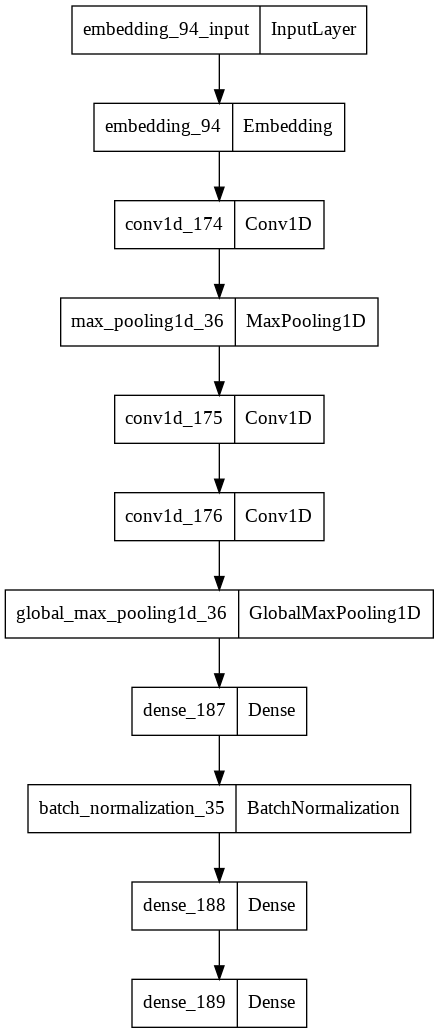

In [539]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

In [540]:
# 학습의 진행
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])    
# ------------------------------------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# ------------------------------------------------------------------------------------
history = model.fit(X_train_np,
                    X_train_target,
                    epochs=15,
                    batch_size=128,
                    validation_data=(X_test_np, X_test_target),
                    verbose=1,callbacks=[es])

Epoch 1/15
934/934 [==============================] - 10s 10ms/step - loss: 0.5181 - accuracy: 0.7267 - val_loss: 0.4114 - val_accuracy: 0.8158
Epoch 2/15
934/934 [==============================] - 7s 7ms/step - loss: 0.3595 - accuracy: 0.8439 - val_loss: 0.3933 - val_accuracy: 0.8255
Epoch 3/15
934/934 [==============================] - 7s 7ms/step - loss: 0.3061 - accuracy: 0.8727 - val_loss: 0.4005 - val_accuracy: 0.8243
Epoch 4/15
934/934 [==============================] - 7s 7ms/step - loss: 0.2745 - accuracy: 0.8893 - val_loss: 0.4110 - val_accuracy: 0.8220
Epoch 4: early stopping


In [541]:
# 데이터셋으로 평가
results = model.evaluate(y_train,  y_target, verbose=2)

print(results)

1555/1555 - 4s - loss: 0.4128 - accuracy: 0.8223 - 4s/epoch - 2ms/step
[0.41281658411026, 0.822289228439331]


In [516]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


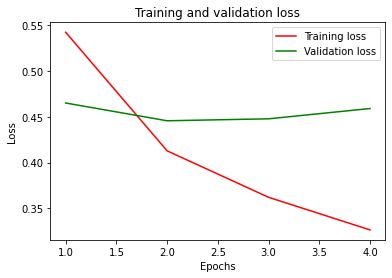

In [517]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r', label='Training loss')

plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

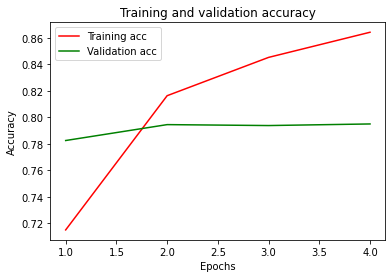

In [518]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

--------
# 7-1-1 pykospacing 전처리 파일로 테스트
------

In [535]:
vocab_size = 25000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(5, 2, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Conv1D(5, 3, activation='relu'))
model.add(tf.keras.layers.Conv1D(5, 4, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_93 (Embedding)    (None, None, 256)         6400000   
                                                                 
 conv1d_171 (Conv1D)         (None, None, 5)           2565      
                                                                 
 max_pooling1d_35 (MaxPoolin  (None, None, 5)          0         
 g1D)                                                            
                                                                 
 conv1d_172 (Conv1D)         (None, None, 5)           80        
                                                                 
 conv1d_173 (Conv1D)         (None, None, 5)           105       
                                                                 
 global_max_pooling1d_35 (Gl  (None, 5)                0         
 obalMaxPooling1D)                                   

In [536]:
# 학습의 진행
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])    
# ------------------------------------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# ------------------------------------------------------------------------------------
history = model.fit(X_train_pyko_np,
                    X_train_pyko_target,
                    epochs=15,
                    batch_size=128,
                    validation_data=(X_test_pyko_np, X_test_pyko_target),
                    verbose=1,callbacks=[es])

Epoch 1/15
934/934 [==============================] - 7s 7ms/step - loss: 0.6063 - accuracy: 0.6435 - val_loss: 0.5004 - val_accuracy: 0.7499
Epoch 2/15
934/934 [==============================] - 6s 7ms/step - loss: 0.4231 - accuracy: 0.7972 - val_loss: 0.4678 - val_accuracy: 0.7721
Epoch 3/15
934/934 [==============================] - 6s 7ms/step - loss: 0.3409 - accuracy: 0.8441 - val_loss: 0.4803 - val_accuracy: 0.7770
Epoch 4/15
934/934 [==============================] - 6s 7ms/step - loss: 0.2911 - accuracy: 0.8688 - val_loss: 0.5087 - val_accuracy: 0.7727
Epoch 4: early stopping


In [537]:
# 데이터셋으로 평가
results_pyko = model.evaluate(y_train_pyko, y_target_pyko, verbose=2)

print(results_pyko)

1555/1555 - 4s - loss: 0.5197 - accuracy: 0.7660 - 4s/epoch - 3ms/step
[0.5196965932846069, 0.7659531831741333]


형태소 기반의 정확도는 0.8223  
공백 기반의 정확도는 0.7660으로 

형태소 기반의 전처리가 더 정확도가 높음을 확인 할 수 있다.

----------
# 7-2 2번째 모델 훈련 및 시각화
----------

- LSTM과 Dense층을 쌓은 모델을 활용해 비교해 보겠다.

In [370]:
vocab_size = 20000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, None, 100)         2000000   
                                                                 
 lstm_20 (LSTM)              (None, 16)                7488      
                                                                 
 dense_86 (Dense)            (None, 8)                 136       
                                                                 
 dense_87 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,007,633
Trainable params: 2,007,633
Non-trainable params: 0
_________________________________________________________________


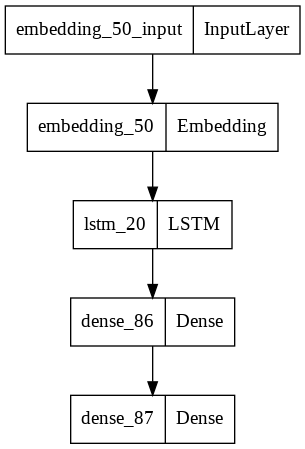

In [371]:
tf.keras.utils.plot_model(
    model2,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

In [372]:
# 학습의 진행
opt2 = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(optimizer=opt2,loss='binary_crossentropy',metrics=['accuracy'])    
# ------------------------------------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# ------------------------------------------------------------------------------------
history2 = model2.fit(X_train_np,
                    X_train_target,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_test_np, X_test_target),
                    verbose=1,callbacks=[es])

Epoch 1/20
467/467 [==============================] - 16s 15ms/step - loss: 0.3877 - accuracy: 0.8235 - val_loss: 0.3459 - val_accuracy: 0.8522
Epoch 2/20
467/467 [==============================] - 5s 10ms/step - loss: 0.3032 - accuracy: 0.8718 - val_loss: 0.3326 - val_accuracy: 0.8569
Epoch 3/20
467/467 [==============================] - 6s 14ms/step - loss: 0.2651 - accuracy: 0.8913 - val_loss: 0.3425 - val_accuracy: 0.8540
Epoch 4/20
467/467 [==============================] - 3s 7ms/step - loss: 0.2341 - accuracy: 0.9062 - val_loss: 0.3457 - val_accuracy: 0.8539
Epoch 4: early stopping


In [373]:
# 데이터셋으로 평가
results2 = model2.evaluate(y_train,  y_target, verbose=2)

print(results2)

1555/1555 - 4s - loss: 0.3511 - accuracy: 0.8515 - 4s/epoch - 3ms/step
[0.351144939661026, 0.851532518863678]


In [374]:
history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


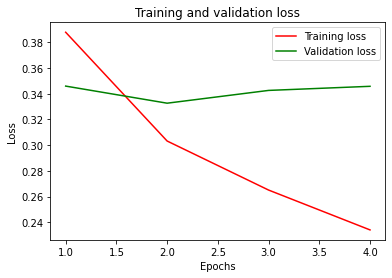

In [375]:
import matplotlib.pyplot as plt

acc2 = history_dict2['accuracy']
val_acc2 = history_dict2['val_accuracy']
loss2 = history_dict2['loss']
val_loss2 = history_dict2['val_loss']

epochs2 = range(1, len(acc2) + 1)

plt.plot(epochs2, loss2, 'r', label='Training loss')

plt.plot(epochs2, val_loss2, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

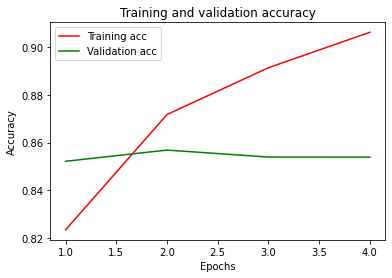

In [376]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs2, acc2, 'r', label='Training acc')
plt.plot(epochs2, val_acc2, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

--------
# 7-2-1 pykospacing 전처리 파일로 테스트
------

In [542]:
vocab_size = 20000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_95 (Embedding)    (None, None, 100)         2000000   
                                                                 
 lstm_32 (LSTM)              (None, 16)                7488      
                                                                 
 dense_190 (Dense)           (None, 8)                 136       
                                                                 
 dense_191 (Dense)           (None, 1)                 9         
                                                                 
Total params: 2,007,633
Trainable params: 2,007,633
Non-trainable params: 0
_________________________________________________________________


In [543]:
# 학습의 진행
opt2 = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model2.compile(optimizer=opt2,loss='binary_crossentropy',metrics=['accuracy'])    
# ------------------------------------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# ------------------------------------------------------------------------------------
history2 = model2.fit(X_train_pyko_np,
                    X_train_pyko_target,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_test_pyko_np, X_test_pyko_target),
                    verbose=1,callbacks=[es])

Epoch 1/20
467/467 [==============================] - 7s 12ms/step - loss: 0.3959 - accuracy: 0.8137 - val_loss: 0.3502 - val_accuracy: 0.8433
Epoch 2/20
467/467 [==============================] - 3s 6ms/step - loss: 0.3059 - accuracy: 0.8655 - val_loss: 0.3425 - val_accuracy: 0.8455
Epoch 3/20
467/467 [==============================] - 3s 6ms/step - loss: 0.2698 - accuracy: 0.8833 - val_loss: 0.3559 - val_accuracy: 0.8402
Epoch 4/20
467/467 [==============================] - 3s 6ms/step - loss: 0.2380 - accuracy: 0.8982 - val_loss: 0.3756 - val_accuracy: 0.8390
Epoch 4: early stopping


In [544]:
# 데이터셋으로 평가
results_pyko2 = model2.evaluate(y_train_pyko, y_target_pyko, verbose=2)

print(results_pyko2)

1555/1555 - 5s - loss: 0.3892 - accuracy: 0.8345 - 5s/epoch - 3ms/step
[0.3892025649547577, 0.8345292210578918]


형태소 기반의 정확도는 0.8515로 루브릭 기준을 달성하였다.
공백 기반의 정확도는 0.8345으로

형태소 기반의 전처리가 더 정확도가 높음을 확인 할 수 있다.  

또한 해당 데이터의 경우 많은 conv1D를 쌓는 것보다는 lstm과 dense층을 쌓아  
가벼운 모델을 만드는 것이 더 정확도를 높이는데 좋다는 점을 확인 할 수 있었다.

--------
# 7-3 3번째 모델 훈련 및 시각화
-------

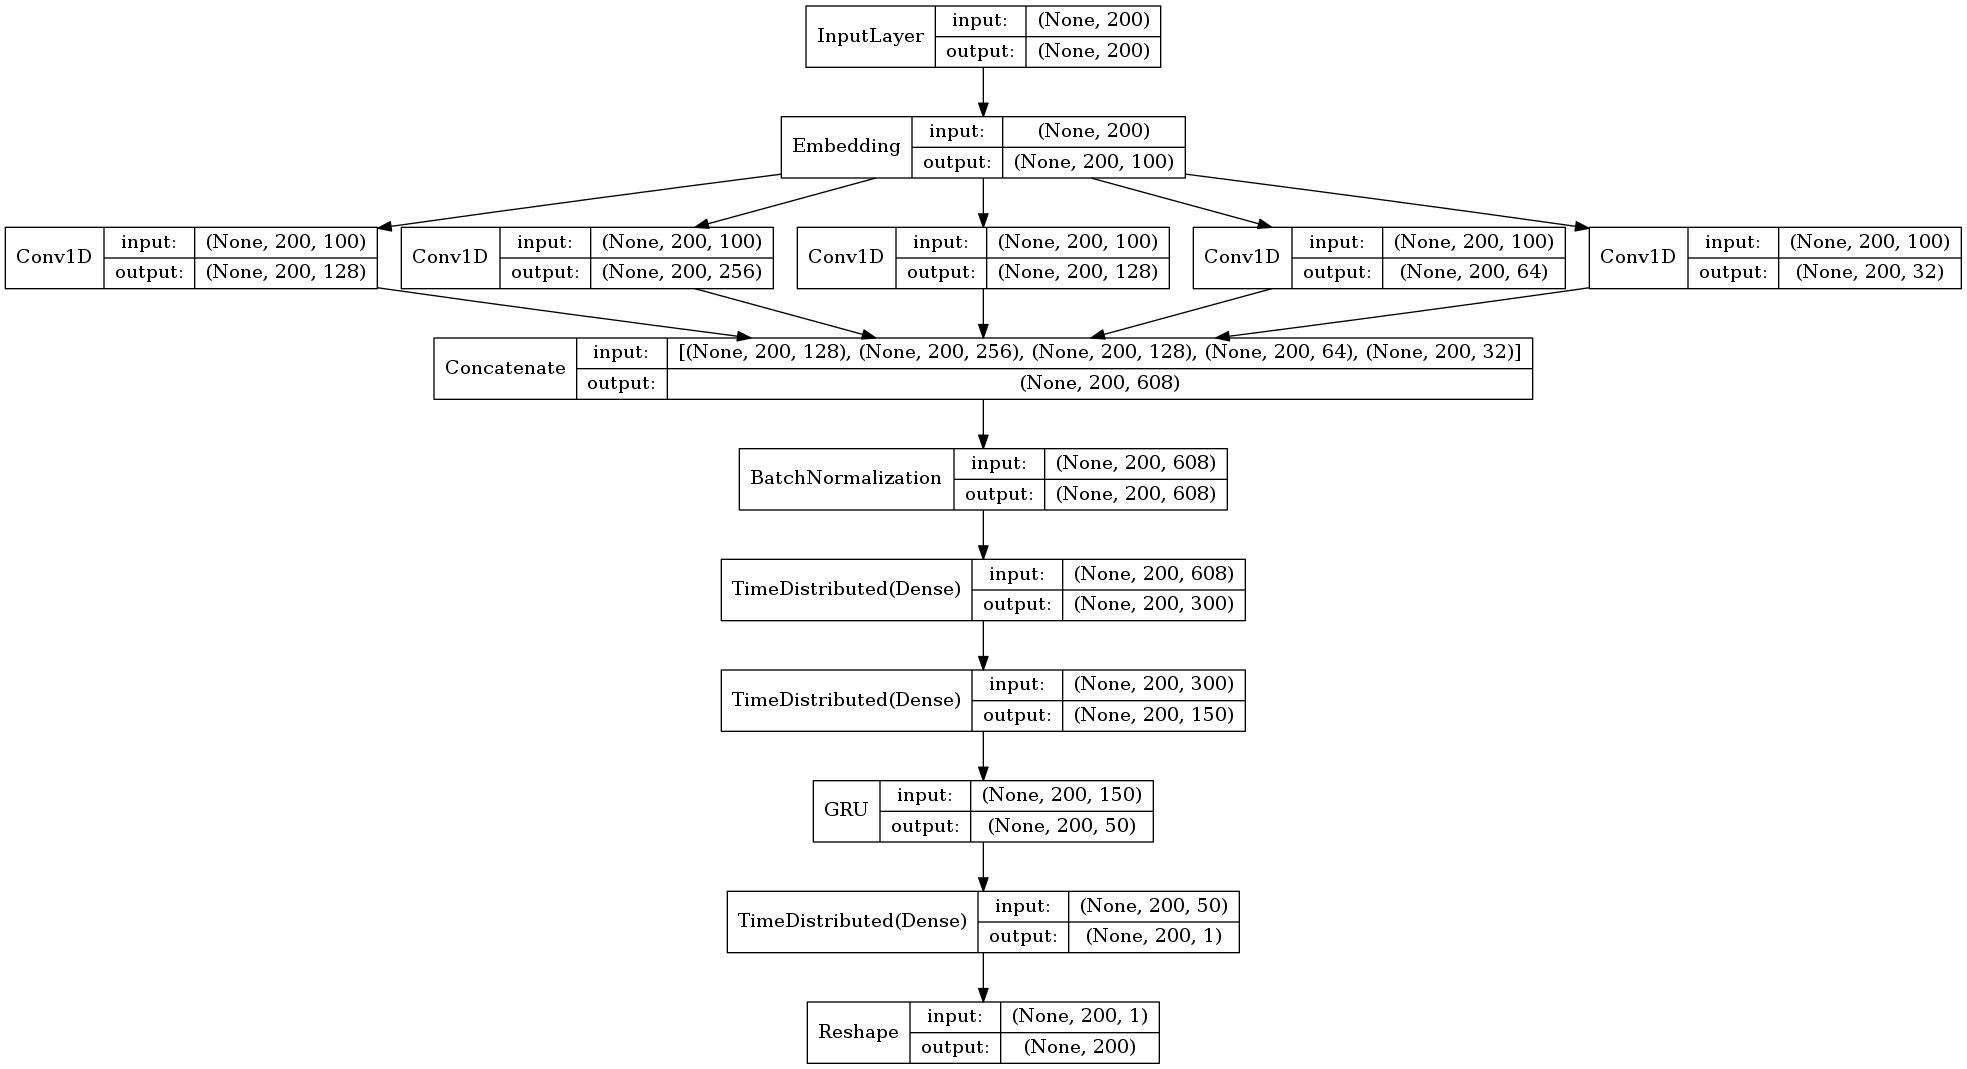

- 3번째 모델은 pykospacing의 모델을 참조해서 비슷한 모양으로 만들어 보았다.   
  위 이미지는 pykospacing의 모델로 임베딩 레이어 이후 conv1D에 여러개 받은 후 concatenate를 한 모델이다. 

- 해당 모델의 경우 여러개의 conv1D와 각기 다른 아웃풋을 통해 초기기억(장기기억)을 잊는 문제에 도움을 줄 수 있는 모델이라 생각된다. 

In [608]:
from keras.layers.merge import concatenate
vocab_size3 = 25000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim3 = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

inputs = tf.keras.Input(shape=(None, ))
embeding = tf.keras.layers.Embedding(vocab_size3, word_vector_dim3)(inputs)
a = tf.keras.layers.Conv1D(5, 2, activation='relu',dilation_rate = 2,padding = 'causal')(embeding)
b = tf.keras.layers.Conv1D(4, 3, activation='relu',dilation_rate = 2,padding = 'causal')(embeding)
c = tf.keras.layers.Conv1D(3, 4, activation='relu',dilation_rate = 4,padding = 'causal')(embeding)
d = tf.keras.layers.Conv1D(5, 5, activation='relu',dilation_rate = 8,padding = 'causal')(embeding)

concatted = tf.keras.layers.Concatenate()([a,b,c,d])

lstm = tf.keras.layers.LSTM(16)(concatted) 
dense1 = tf.keras.layers.Dense(8, activation='relu')(lstm)
dense2 = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

models = tf.keras.Model(inputs=inputs, outputs=dense2)

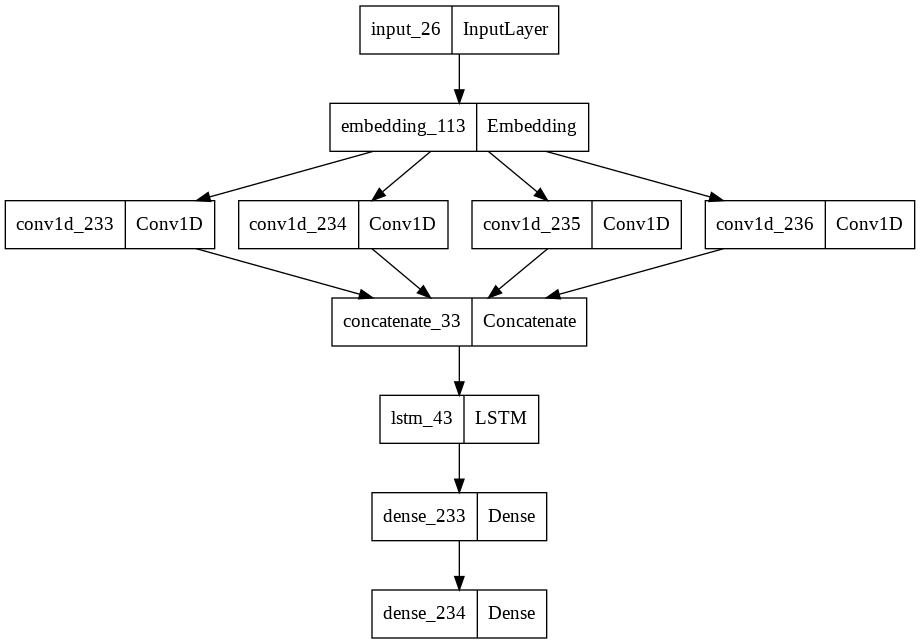

In [609]:
tf.keras.utils.plot_model(
    models,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

In [610]:
# 학습의 진행
opt3 = tf.keras.optimizers.RMSprop(learning_rate=0.01)
models.compile(optimizer=opt3,loss='binary_crossentropy',metrics=['accuracy'])    
# ------------------------------------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# ------------------------------------------------------------------------------------
history3 = models.fit(X_train_np,
                    X_train_target,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_test_np, X_test_target),
                    verbose=1,callbacks=[es])

Epoch 1/20
467/467 [==============================] - 12s 20ms/step - loss: 0.3974 - accuracy: 0.8166 - val_loss: 0.3552 - val_accuracy: 0.8453
Epoch 2/20
467/467 [==============================] - 7s 14ms/step - loss: 0.3213 - accuracy: 0.8631 - val_loss: 0.3865 - val_accuracy: 0.8255
Epoch 3/20
467/467 [==============================] - 7s 15ms/step - loss: 0.2903 - accuracy: 0.8782 - val_loss: 0.3573 - val_accuracy: 0.8447
Epoch 3: early stopping


In [611]:
# 데이터셋으로 평가
results3 = models.evaluate(y_train,  y_target, verbose=2)

print(results3)

1555/1555 - 7s - loss: 0.3648 - accuracy: 0.8404 - 7s/epoch - 5ms/step
[0.3647691607475281, 0.8403979539871216]


In [612]:
history_dict3 = history3.history
print(history_dict3.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


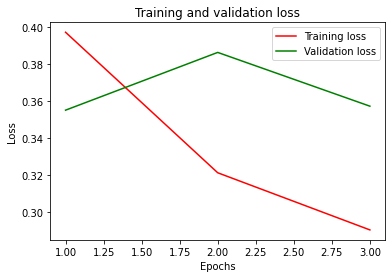

In [613]:
import matplotlib.pyplot as plt

acc3 = history_dict3['accuracy']
val_acc3 = history_dict3['val_accuracy']
loss3 = history_dict3['loss']
val_loss3 = history_dict3['val_loss']

epochs3 = range(1, len(acc3) + 1)

plt.plot(epochs3, loss3, 'r', label='Training loss')

plt.plot(epochs3, val_loss3, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

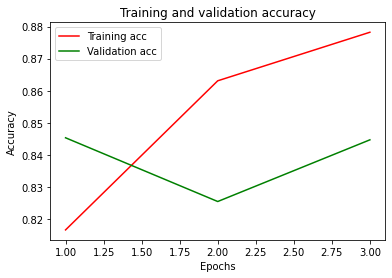

In [614]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs3, acc3, 'r', label='Training acc')
plt.plot(epochs3, val_acc3, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

--------
# 7-3-1 pykospacing 전처리 파일로 테스트
------

In [615]:
from keras.layers.merge import concatenate
vocab_size3 = 25000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim3 = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

inputs = tf.keras.Input(shape=(None, ))
embeding = tf.keras.layers.Embedding(vocab_size3, word_vector_dim3)(inputs)
a = tf.keras.layers.Conv1D(5, 2, activation='relu',dilation_rate = 2,padding = 'causal')(embeding)
b = tf.keras.layers.Conv1D(4, 3, activation='relu',dilation_rate = 2,padding = 'causal')(embeding)
c = tf.keras.layers.Conv1D(3, 4, activation='relu',dilation_rate = 4,padding = 'causal')(embeding)
d = tf.keras.layers.Conv1D(5, 5, activation='relu',dilation_rate = 8,padding = 'causal')(embeding)

concatted = tf.keras.layers.Concatenate()([a,b,c,d])

lstm = tf.keras.layers.LSTM(16)(concatted) 
dense1 = tf.keras.layers.Dense(8, activation='relu')(lstm)
dense2 = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

models = tf.keras.Model(inputs=inputs, outputs=dense2)

In [616]:
# 학습의 진행
opt3 = tf.keras.optimizers.RMSprop(learning_rate=0.01)
models.compile(optimizer=opt3,loss='binary_crossentropy',metrics=['accuracy'])    
# ------------------------------------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# ------------------------------------------------------------------------------------
history3 = models.fit(X_train_pyko_np,
                    X_train_pyko_target,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_test_pyko_np, X_test_pyko_target),
                    verbose=1,callbacks=[es])

Epoch 1/20
467/467 [==============================] - 10s 16ms/step - loss: 0.4078 - accuracy: 0.8090 - val_loss: 0.3693 - val_accuracy: 0.8321
Epoch 2/20
467/467 [==============================] - 5s 11ms/step - loss: 0.3094 - accuracy: 0.8653 - val_loss: 0.3558 - val_accuracy: 0.8371
Epoch 3/20
467/467 [==============================] - 7s 15ms/step - loss: 0.2673 - accuracy: 0.8857 - val_loss: 0.3590 - val_accuracy: 0.8393
Epoch 4/20
467/467 [==============================] - 5s 11ms/step - loss: 0.2325 - accuracy: 0.9029 - val_loss: 0.4104 - val_accuracy: 0.8301
Epoch 4: early stopping


In [617]:
# 데이터셋으로 평가
results3 = models.evaluate(y_train_pyko,  y_target_pyko, verbose=2)

print(results3)

1555/1555 - 7s - loss: 0.4200 - accuracy: 0.8262 - 7s/epoch - 4ms/step
[0.42000722885131836, 0.8262486457824707]


형태소 기반의 정확도는 0.8404  
공백 기반의 정확도는 0.8262으로  

형태소 기반의 전처리가 더 정확도가 높음을 확인 할 수 있다.

LSTM모델만 사용했던것 봐는 비슷한 수준의 정확도를 보이고 있다.  
하이퍼라마미터를 조금 더 조절하면 루브릭 기준도 달성할 수 있을 것이라 생각된다.

------
# 8.학습된 Embedding 레이어 분석
-----

In [320]:
# 단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법
embedding_layer = model2.layers[0]            # GRU로 학습된 모델을 대상으로 분석 
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(20000, 100)


In [326]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/aiffel/Exp9/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [328]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.04157062,  0.5136168 , -0.23214592,  1.1496644 , -0.4600534 ,
       -0.10446735,  0.6106046 ,  0.00950412, -0.14411397,  0.7769612 ,
       -0.14936337,  0.22949103, -0.2506666 , -0.78848195, -0.7103162 ,
        0.43029374,  0.48667243, -0.69486594,  0.675149  , -0.877025  ,
       -1.2018963 , -0.635225  ,  0.09749448,  0.9453681 , -0.05299523,
       -0.35234702, -0.26999724,  0.58889306,  0.09428804, -0.5320371 ,
       -0.69451666, -0.01027953,  0.04448956, -0.08019513, -0.50607574,
        0.23373854,  0.35398424,  1.7156942 , -0.9404135 , -0.28598052,
       -0.7910834 ,  0.54644597,  0.14478546, -0.6372022 , -0.18373689,
        0.41470394,  0.3027126 ,  0.8604386 ,  0.12417792, -0.9723727 ,
       -0.43619752,  0.7467186 ,  0.9654289 ,  0.79037255, -0.54165494,
        0.10675228,  0.57408476,  0.25514087, -0.15021175, -0.13956809,
       -0.11017565,  0.36775362,  0.02050332, -0.12313519,  0.51343817,
       -0.16996518, -0.27385694, -0.79381955, -0.3720347 ,  0.29

In [330]:
# 단어를 하나 주고 가장 유사한 단어와 유사도 확인
word_vectors.similar_by_word("재미")

[('맛있', 0.8296180963516235),
 ('스릴', 0.827806830406189),
 ('공감', 0.8260442018508911),
 ('재', 0.8210722208023071),
 ('랩', 0.8153469562530518),
 ('짜임새', 0.8129761219024658),
 ('흥미', 0.8118231892585754),
 ('희생', 0.8052337169647217),
 ('뽀', 0.7989502549171448),
 ('중심', 0.7987802028656006)]

------
# 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선
------

In [333]:
# 한국어 Word2Vec 임베딩 활용한 성능 개선
from gensim.models import Word2Vec

word2vec_path = '/content/drive/MyDrive/aiffel/Exp9/ko/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

vector = word2vec['재미']
vector  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


array([-0.01228145, -0.4937083 ,  0.4424771 , -1.0789338 , -1.0551587 ,
       -0.8106456 , -0.0881472 ,  0.7738013 , -0.3837249 , -0.31405708,
        0.18792619, -0.04978764,  0.3977235 ,  1.0052139 , -0.5921918 ,
        0.57315415, -0.13287784,  1.4190367 ,  0.5338879 ,  0.08187074,
       -0.21017547, -0.31960285,  0.08991678, -0.06743078,  0.14399454,
        0.04861213,  0.4904712 ,  0.38203648, -0.33213428, -0.48618734,
       -0.6996383 , -0.48903087, -0.5666092 ,  0.11454912,  0.7527777 ,
       -1.6491356 ,  0.709264  ,  0.14231981,  1.2408166 ,  0.9104645 ,
        1.0235597 , -0.7135743 , -0.5323588 , -0.16439462, -0.12318534,
       -0.41341293,  0.76286334, -0.24337888, -1.0924134 , -0.78981435,
        0.24504295, -0.472915  , -0.17546178,  0.10006592, -1.2155428 ,
        0.4059387 ,  0.8259838 , -0.18593056, -0.21122731, -0.46615708,
        0.74433243, -0.18605745, -0.9175297 ,  0.08531424,  0.09134697,
       -0.60375917,  0.5236646 ,  0.7689134 ,  0.19123535,  0.60

In [334]:
# 단어를 하나 주고 가장 유사한 단어와 유사도 확인
word2vec.similar_by_word("재미")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

-----
# 9-1. 전이학습
-----

In [619]:
vocab_size = 25000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


-----
# 9-2 학습된 모델 사용 
-----

In [629]:
from tensorflow.keras.initializers import Constant


model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=50, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model4.summary()

Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_117 (Embedding)   (None, 50, 200)           5000000   
                                                                 
 lstm_46 (LSTM)              (None, 16)                13888     
                                                                 
 dense_239 (Dense)           (None, 8)                 136       
                                                                 
 dense_240 (Dense)           (None, 1)                 9         
                                                                 
Total params: 5,014,033
Trainable params: 5,014,033
Non-trainable params: 0
_________________________________________________________________


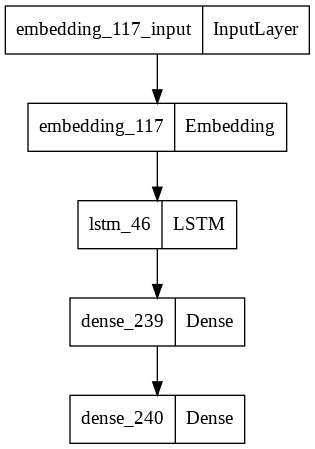

In [630]:
tf.keras.utils.plot_model(
    model4,
    to_file='model.png',
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB'
)

In [631]:
X_train_np = np.array(X_train['document'])
X_test_np = np.array(X_test['document'])
X_train_target = np.array(X_train['label'])
X_test_target = np.array(X_test['label'])
y_train = test_data['document']
y_target = test_data['label']

In [632]:
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',maxlen=50)
X_train_np= tf.keras.preprocessing.sequence.pad_sequences(X_train_np,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',maxlen=50)
# --------------------------------------------------------------------------------------------------
X_test_np= tf.keras.preprocessing.sequence.pad_sequences(X_test_np,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',maxlen=50)

In [633]:
# 학습의 진행
opt4 = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model4.compile(optimizer=opt4,loss='binary_crossentropy',metrics=['accuracy'])    
# ------------------------------------------------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# ------------------------------------------------------------------------------------
history4 = model4.fit(X_train_np,
                    X_train_target,
                    epochs=20,
                    batch_size=256,
                    validation_data=(X_test_np, X_test_target),
                    verbose=1,callbacks=[es])

Epoch 1/20
467/467 [==============================] - 6s 8ms/step - loss: 0.4258 - accuracy: 0.8029 - val_loss: 0.3756 - val_accuracy: 0.8357
Epoch 2/20
467/467 [==============================] - 3s 7ms/step - loss: 0.3409 - accuracy: 0.8533 - val_loss: 0.3703 - val_accuracy: 0.8363
Epoch 3/20
467/467 [==============================] - 3s 7ms/step - loss: 0.3127 - accuracy: 0.8686 - val_loss: 0.3678 - val_accuracy: 0.8445
Epoch 4/20
467/467 [==============================] - 3s 7ms/step - loss: 0.2935 - accuracy: 0.8781 - val_loss: 0.3659 - val_accuracy: 0.8424
Epoch 5/20
467/467 [==============================] - 3s 7ms/step - loss: 0.2771 - accuracy: 0.8865 - val_loss: 0.3702 - val_accuracy: 0.8432
Epoch 6/20
467/467 [==============================] - 3s 7ms/step - loss: 0.2632 - accuracy: 0.8927 - val_loss: 0.3768 - val_accuracy: 0.8437
Epoch 6: early stopping


In [634]:
# 데이터셋으로 평가
results4 = model4.evaluate(y_train,  y_target, verbose=2)

print(results4)

1555/1555 - 5s - loss: 0.3810 - accuracy: 0.8420 - 5s/epoch - 3ms/step
[0.38101282715797424, 0.8420460224151611]


In [635]:
history_dict4 = history4.history
print(history_dict4.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


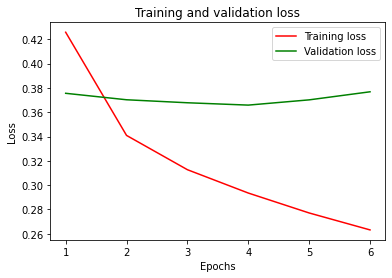

In [636]:
import matplotlib.pyplot as plt

acc4 = history_dict4['accuracy']
val_acc4 = history_dict4['val_accuracy']
loss4 = history_dict4['loss']
val_loss4 = history_dict4['val_loss']

epochs4 = range(1, len(acc4) + 1)

plt.plot(epochs4, loss4, 'r', label='Training loss')

plt.plot(epochs4, val_loss4, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

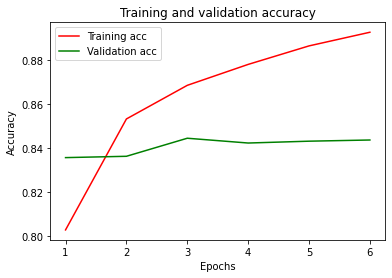

In [637]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs4, acc4, 'r', label='Training acc')
plt.plot(epochs4, val_acc4, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

-------
# 10. 회고
-----

- 2가지를 비교하기에 앞서 한국어의 경우 형태소를 기반으로 하는 전처리의 성능이 더 좋다는 사실을 들었고, 해당 사실을 확인해 보기 위해 서로 비교를 해보았다.

- 2가지를 비교하기 전 conv1D Layer와 LSTM Layer의 모델을 비교하면서 형태소가 더 성능이 뛰어날 것이라는 생각을 가지고 있었다.  

- LSTM 모델의 경우 생각대로 형태소 기반의 전처리가 더 정확도가 높았다. 하지만 conv1D모델의 경우 Layer는 그대로 두고 하이퍼파라미터를 변경하면서 확인해 보았지만 의외로 공백 기반의 전처리가 더 높은 정확도를 보여주었다.   
  (여러가지 변경을 하다보니 결과를 시각적으로 확인할 수 있는 값들은 지워졌다. 내가 느꼈던 생각과 과정을 글로만 정리를 해보려한다.)

- 해당 이유에 대해서 고민한 결과 conv1D와 비교하여 장기기억의 이점을 가지고 있는 LSTM 모델이 장기기억을 가지면서 더 정확도가 높아지는 것이라는 가설을 세웠다. 이전 conv1D 모델에서 conv1D Layer를 늘려 노드를 줄이는 과정에서 초기기억(장기기억)을 유지할 수 있게 늘렸으며, conv1D를 늘리기 위해 pooling의 수도 줄여보았다. 

- 그 결과 cov1D 모델도 형태소 기반의 전처리에서 더 높은 정확도를 보임을 확인할 수 있었다.
- 또한 3번째 모델에서 conv1D의 값을 다르게해 병렬적으로 Layer를 쌓고, concatenate를 통해 합치는 과정에서 초기기억(장기기억)이 유실되는 문제점도 해결할 수 있는 방식의 모델이라고 생각이 들었으며, 해당 모델 역시 가설을 확인하는 과정에서 입증에 도움이 되는 모델이라는 생각이 들었다.

- 가설을 입증하는 과정에서 명확한 방법을 통해 입증을 한 것은 아니지만 가설을 고민하고 확인하는 과정에서 Layer에 대한 이해를 조금 더 늘릴 수 있었으며, 해당 이유에 대해 여러사람과 같이 고민하는 과정이 다소 재밌는 경험이었다.